In [2]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
# Classifier from TF hub
classifier_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2' #@param {type:"string"}
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [12]:
# Single image demo
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
# display(grace_hopper)

grace_hopper = np.array(grace_hopper)/255.0
print(f'Input shape: {grace_hopper.shape}')

result = classifier.predict(grace_hopper[np.newaxis, ...])
print(f'Output shape: {result.shape}')

predicted_class = np.argmax(result[0], axis=-1)
print(f'Predicted class idx: {predicted_class}')

Input shape: (224, 224, 3)
Output shape: (1, 1001)
Predicted class idx: 653


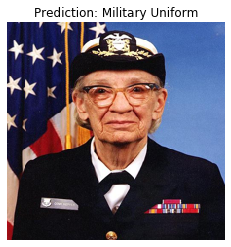

In [13]:
# Check predicted result label
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [18]:
# Dataset: flowers
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
print(f'Dataset root {data_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

Dataset root /home/harny/.keras/datasets/flower_photos
Found 3670 images belonging to 5 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 5)


Batch result shape: (32, 1001)
Batch predicted class names: ['artichoke' 'daisy' 'pot' 'vase' 'coral fungus' 'pinwheel' 'buckeye'
 'daisy' 'cardoon' 'daisy' 'rapeseed' 'croquet ball' 'daisy' 'daisy'
 'daisy' 'tarantula' 'daisy' 'cardoon' 'quill' 'bakery' 'bee'
 'picket fence' 'rapeseed' 'limpkin' 'bell pepper' 'rapeseed' 'daisy'
 'daisy' 'daisy' 'tiger cat' 'bee' 'daisy']


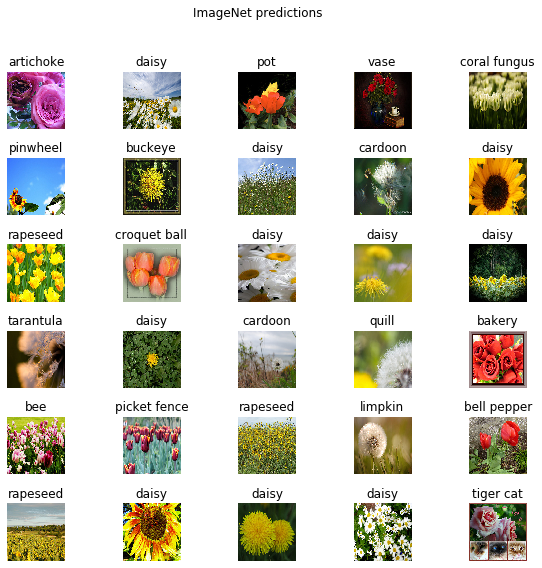

In [21]:
# Predict batch input
result_batch = classifier.predict(image_batch)
print(f'Batch result shape: {result_batch.shape}')

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(f'Batch predicted class names: {predicted_class_names}')

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

In [23]:
# Prepare transfer learning
## Download headless (without the top classification layer) model
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2' #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

## Frozen feature extraction layer
feature_extractor_layer.trainable = False

## Make a model for classification
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

(32, 1280)


In [28]:
## Check the model and prediction result
model.summary()

predictions = model(image_batch)
print(f'Prediction shape: {predictions.shape}')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
Prediction shape (32, 5)


In [32]:
# Train build
## Compile model for train
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

## Log class
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 43s 371ms/step - loss: 0.7005 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 44s 385ms/step - loss: 0.3460 - acc: 0.9062


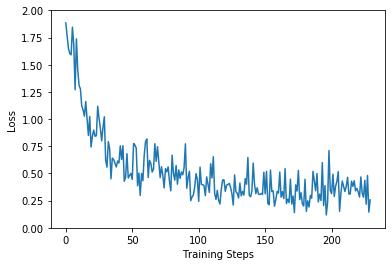

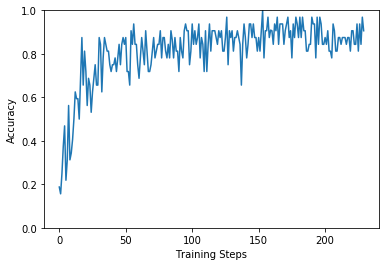

In [34]:
# Draw loss rate
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

# Draw accurary
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

Classes: ['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


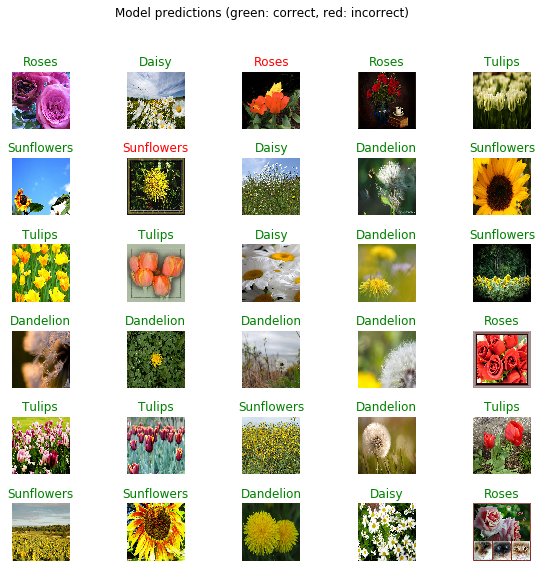

In [35]:
# Plot results
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

## get result labels
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [37]:
# Export model
import time
t = time.time()

export_path = f'/tmp/saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

INFO:tensorflow:Assets written to: /tmp/saved_models/1579826611/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1579826611/assets


Export the model to /tmp/saved_models/1579826611


In [ ]:
# Check the exported model
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

